# **Section 2: Predicting Occupancy using Machine Learning**
### **Objective:** train and test a machine learning classification model to accurately predict the number of occupants in a room based on environmental factors.
# *Classification in Machine Learning*
Classification involves assigning data points to discrete labels. For instance:
- **Features** (*independent variables*): temperature, humidity, light, CO2 levels.

- **Labels** (*dependent variable/prediction*): categories like 'occupied' and 'unoccupied' or the number of occupants.

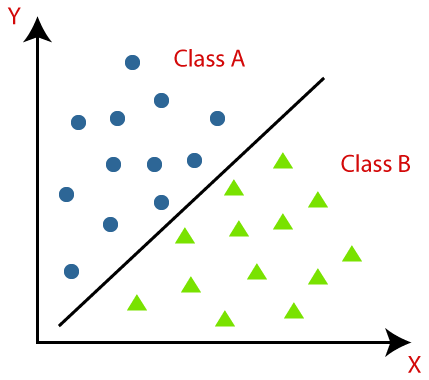

> **Discrete vs. Continuous: Discrete data are distinct/countable (number of marbles in a jar, colours of traffic lights, etc.). Continuous data are smooth and infinite (e.g. temperature measurements).*

# [*K-Nearest Neighbors (KNN)*](<https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20(KNN,of%20an%20individual%20data%20point.>)
 - A simple classification algorithm that labels a new data point based on the label of majority of its 'k' nearest neighbors.
 - A supervised algorithm, meaning it uses labeled datasets, learning to predict target labels with guidance from known outcomes.

### **KNN with 2 Features**
We'll begin with a simple two-feature dataset to demonstrate KNN on a 2D Cartesian graph.

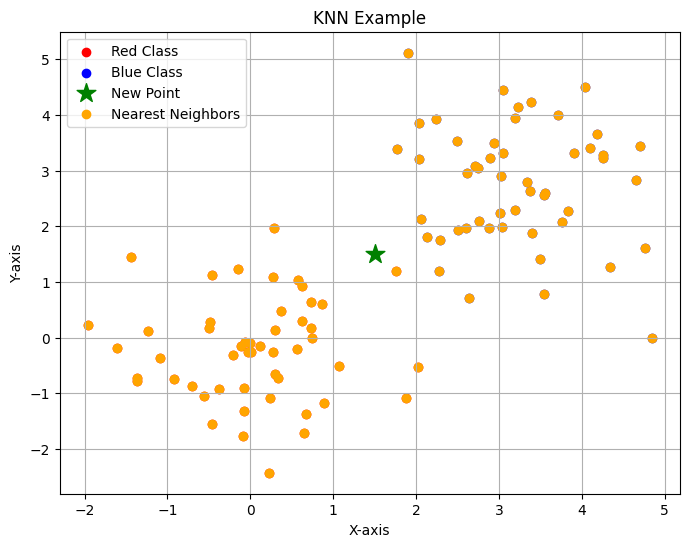

In [29]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Generate data
X_red = np.random.normal(loc=0.0, scale=1.0, size=(50, 2))
X_blue = np.random.normal(loc=3.0, scale=1.0, size=(50, 2))

# Draw the empty graph
plt.figure(figsize=(8, 6)) # Create new 8x6 figure
plt.title('KNN Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plot data (markers are dots by default)
plt.scatter(X_red[:, 0], X_red[:, 1], color='red', label='Red Class')
plt.scatter(X_blue[:, 0], X_blue[:, 1], color='blue', label='Blue Class')

# Plot new data point, hardcoded (1.5, 1.5), as a star
new_point = np.array([[1.5, 1.5]])  # coordinates of the new point
plt.scatter(new_point[:, 0], new_point[:, 1], color='green', marker='*', s=200, label='New Point')

k = 5 # How many nearest neighbours to find

# Combine the two datasets
all_points = np.vstack([X_red, X_blue])

# Calculate each point's distance from the new point.
distances = np.linalg.norm(all_points - new_point, axis=1)

# Sort neighbours by distance
nearest_indices = np.argsort(distances)
nearest_points = all_points[nearest_indices]
plt.scatter(nearest_points[:, 0], nearest_points[:, 1], color='orange', label='Nearest Neighbors')

plt.legend() # the key
plt.grid(True) # show gridlines

### **Explanation of the Code Above**

**1. Generating and Plotting Random Data:**
- **Libraries** provide nifty pre-written code and functionality. We use `numpy` for numerical operations and `matplotlib.pyplot` for plotting.

- `np.random.normal` generates two datasets following a [normal distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html), 
representing our two classes.

- `matplotlib.pyplot.scatter` plots the generated data points.

**2. Finding Nearest Neighbors:**
- `np.vstack` combines the datasets X_red and X_blue into a single array.

- `np.argsort(distances)` returns the indices that would sort the distances array in ascending order.

- `nearest_points` *should* select the k nearest points

### *Your Turn*
*a) The HVAC datasets have 5 features. Why would this make it difficult to visualise the KNN process?*


*b) What do you think the parameters `loc`, `scale`, and `size` represent in the `np.random.normal` function?*
  
*c) All the points are orange! Our code highlights all of them rather than the `k` nearest subset. Edit `line 32` to fix this. (Hint: use [list slicing](https://www.w3schools.com/python/python_lists_access.asp))**

*d) Will the new point be classed as `Red` or `Blue` when `k=3`?*
  
*e) Try changing the value of `k` and see what happens. What is the issue with having an even value of `k`?*

# *KNN with the HVAC Data*
- We have three datasets - one for training the model, and two for testing the trained model's prediction accuracy. 

- In each of our HVAC datasets, data points (air quality factor combinations/independent variables) are labeled with the true number of observed occupants (dependent variable).

## **1. Importing Libraries and Reading the Data**
First, we need to import the necessary libraries and read the data.


In [30]:
import pandas as pd
import plotly.express as px
from plotly.offline import iplot

# One dataset for training the model
datatraining = pd.read_csv('datatraining.csv')
# Two datsets for testing model performance
datatest = pd.read_csv('datatest.csv')
datatest2 = pd.read_csv('datatest2.csv')

# Convert date columns to datetime if present and reset index
datatraining['date'] = pd.to_datetime(datatraining['date'])
datatest['date'] = pd.to_datetime(datatest['date'])
datatest2['date'] = pd.to_datetime(datatest2['date'])

datatraining.reset_index(drop=True, inplace=True)
datatest.reset_index(drop=True, inplace=True)
datatest2.reset_index(drop=True, inplace=True)

### **Explanation of the Code Above**
The code above imports the necessary libraries, classes, and functions:
- `pandas`: Library imported for data analysis and manipulation. It provides data structures like DataFrames to handle tabular data.

- `plotly.express`: Class that acts as an interface for more easily creating interactive plots with Plotly.

- `iplot from plotly.offline`: Function for displaying interactive plots inline within Jupyter notebooks.

...and read the datasets into pandas [DataFrames](https://www.w3schools.com/python/pandas/pandas_dataframes.asp)

We also convert the date columns to datetime objects if they are present and reset the indices of the DataFrames for cleaner data handling.

## **2. What Our Data Looks Like**

Each of our three datasets have the same structure. Let's use the dataset.head() method from `pandas` to view display the first few rows of the training DataFrame.

In [31]:
datatraining.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


As you can see, we have readings for each of the independent variables and the observed number of occupants at 1 minute intervals. 

### **Air Quality Factors and Occupancy Over Time**
Before we dive into training our model, let's have a look at how `temperature`, `humidity`, `light`, `CO2`, and `HumidityRatio` vary over time.

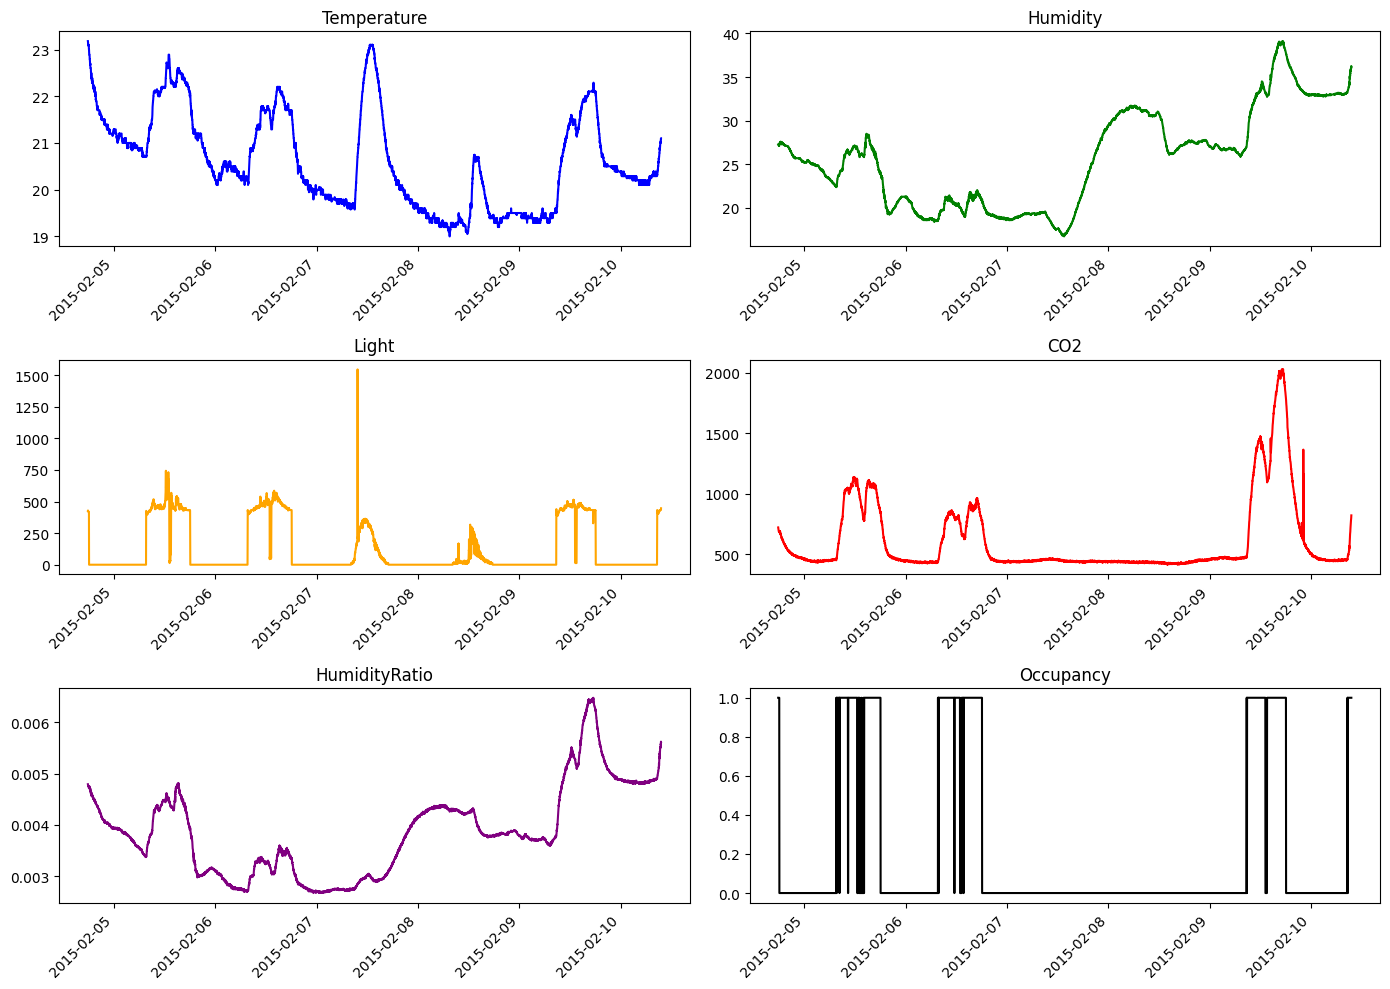

In [32]:
# Define the feature columns
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

# Plot the training dataset
# We use separate graphs, rather than a 5D plot, for clarity
plt.figure(figsize=(14, 10))
columns_to_plot = columns + ['Occupancy']
colors = ['blue', 'green', 'orange', 'red', 'purple', 'black']

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(3, 2, i)
    plt.plot(datatraining['date'], datatraining[column], color=colors[i-1])
    plt.title(column)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

### *Your Turn*
*a) By reading the graphs above, give approximate ranges for temperature, humidity, light, CO2 and humidity ratio.*

*b) What do you notice about these ranges?*

*c) What can you say about the number of occupants in this room at any given time?*

## **3. Preparing the Data**
- In machine learning, **data preprocessing** is essential for ensuring that the data is clean and formatted correctly before being fed into algorithms.

- This involves *handling missing values*, *removing noise*, *normalising features*, and *encoding categorical variables*. 

- By preprocessing the data, we enhance its quality, reduce biases, and enable algorithms to extract meaningful patterns efficiently, resulting in more accurate predictions.

- Preprocessing is a vast topic. In this project we will apply what's arguably the most important preprocessing step - *normalisation*

### **Scaling and Normalisation**
- When a model looks at data features, it tries to understand how changes in each feature affect the prediction.

- In our dataset the values for light and temperature are on completely different scales. 

- The model gives more importance to light simply because its values are larger, even if temperature is more relevant for predicting occupancy. 

- This inconsistency in scales can lead to features with larger values dominiating model training, resulting in a model that makes poor predictions.  

- As we don't know which features are actually more important, we bring the features to the same scale via **normalisation** to ensure they are considered equally.

- `sklearn` provides multiple normalisation methods, including MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, and more.

### **Normalising Our Data using Min-Max**
- The *Min-Max* technique scales features to a specified range, typically between 0 and 1, by calculating the min and max values of each feature and scaling the data accordingly.

- Let's use boxplots to see how MiniMax scaling affects the spread (mean, median and range) of each independent variable.

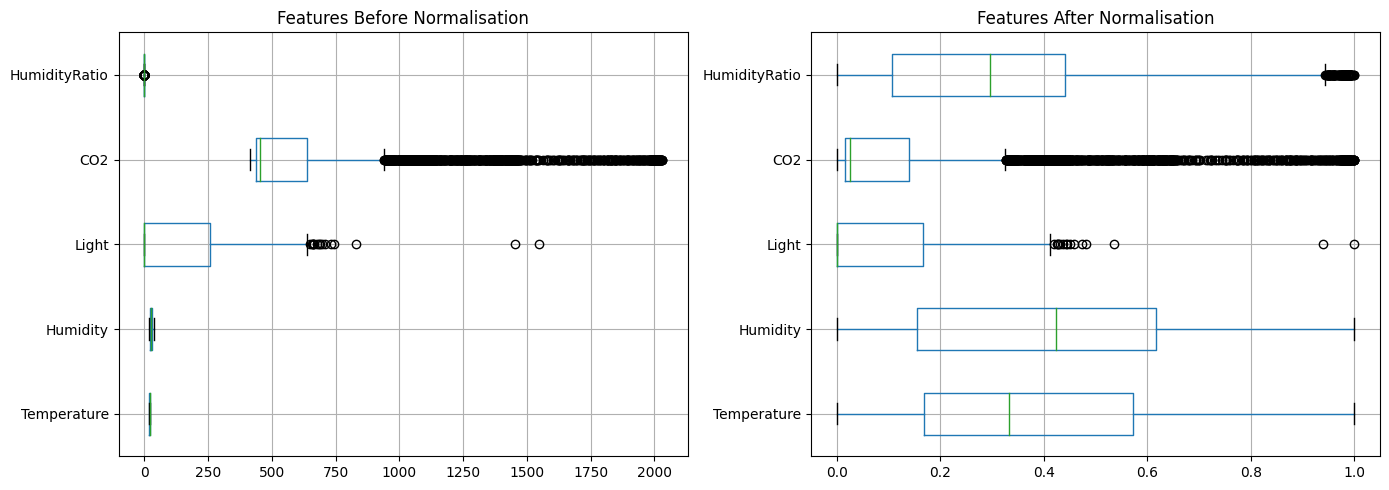

In [33]:
from sklearn.preprocessing import MinMaxScaler 
# ...can also import StandardScaler, MaxAbsScaler, RobustScaler and more from the 'sklearn.preprocessing' class

# Show the boxplots side by side in one figure
plt.figure(figsize=(14, 5))

# Boxplot before normalisation
plt.subplot(1, 2, 1) # first column (left plot)
datatraining.boxplot(column=columns, vert=False)
plt.title('Features Before Normalisation')

# Scale the data to range 0-1
scaler = MinMaxScaler() # **** a) CHANGE THIS ****
datatraining_normalized = datatraining.copy()  # Create a copy of the DataFrame for normalized data
datatraining_normalized[columns] = scaler.fit_transform(datatraining_normalized[columns])

# Boxplot after normalisation
plt.subplot(1, 2, 2) # second column (right plot)
datatraining_normalized.boxplot(column=columns, vert=False)
plt.title('Features After Normalisation')

plt.tight_layout() # Adjust layout

### *Challenge*
Try another normalisation method on `datatraining`. Does it have a different effect than MinMax on the spread of data? (See [this page ](https://pieriantraining.com/complete-guide-to-feature-scaling-in-scikit-learn/)for how to use the alternative methods)

### **3. Model Training and Testing**


In [36]:
# Define features and target for training and testing datasets
X_train = datatraining.drop(columns=['date', 'Occupancy'], axis=1)
y_train = datatraining['Occupancy']
X_validation = datatest.drop(columns=['date', 'Occupancy'], axis=1)
y_validation = datatest['Occupancy']
X_test = datatest2.drop(columns=['date', 'Occupancy'], axis=1)
y_test = datatest2['Occupancy']


### **Testing Classifiers Against Different Hyperparameters**
- Unlike parameters (features), which determine the model itself, hyperparameters specify details of the **learning process**. 

- For example, how many neighbours to consider or how to measure the distance between points**.

- We cannot tell beforehand which combination of hyperparamets will yield the most accurate trained model, so we try a bunch and see.

> ***Manhattan, or L1, distance calculates the total distance traveled along the axes of a grid. In contrast, Euclidean, or L2 distance, measures the shortest straight-line path between two points*

In [37]:

# parameter-tuning for knn
n_neighbors_list = [7,15,45,135]
metric_list = ['euclidean', 'manhattan']

accuracies = {}
from sklearn.neighbors import KNeighborsClassifier
for n in n_neighbors_list:
    for metric in metric_list:
        knn_model = KNeighborsClassifier(n_neighbors=n, metric=metric)
        knn_model.fit(X_train, y_train)
        accuracy = knn_model.score(X_validation, y_validation)
        accuracies["k="+str(n)+"/"+metric] = accuracy

plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Accuracy'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Accuracy")
fig.update_layout(title={'text': "Accuracies for Different Hyper-Parameters",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

# **Summary**

### **Classification**:
   - A machine learning task where data points are assigned to discrete categories or labels.
   - Involves predicting the class or category of a data point based on its features.

### **K-Nearest Neighbors (KNN)**:
   - A simple classification algorithm that assigns labels to data points based on the majority label of their nearest neighbors.
   - Does not require training and stores all available data, making it easy to implement.

### **Preprocessing**:
   - Involves preparing and cleaning data before feeding it into a machine learning model.
   - Includes handling missing values, removing noise, and transforming data into a usable format.

### **Normalisation**:
   - Preprocessing technique that scales the features of a dataset to a similar range.
   - Ensures that all features contribute equally to the model's learning process.

### **Hyperparameters**:
   - Settings that control the learning process of a machine learning model.
   - Not learned from the data but are set before training and tuning.
   - Examples include the number of neighbors in KNN and the choice of distance metric.

**Each of these concepts play a crucial role in building and optimising machine learning models for classification tasks.**

[Sources: OMER TURKSOY](https://www.kaggle.com/code/turksoyomer/hvac-occupancy-detection-with-ml-and-dl-methods#3.-Classification-with-Machine-Learning-Methods)